In [1]:
# data from:
# https://www.kaggle.com/uciml/sms-spam-collection-dataset
!wget https://lazyprogrammer.me/course_files/spam.csv

--2023-06-16 12:56:22--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: 'spam.csv.1'

spam.csv.1          100%[===================>] 491.86K   704KB/s    in 0.7s    

2023-06-16 12:56:24 (704 KB/s) - 'spam.csv.1' saved [503663/503663]



In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from wordcloud import WordCloud

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

2023-06-16 12:56:30.866778: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv("spam.csv", encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)

<AxesSubplot:>

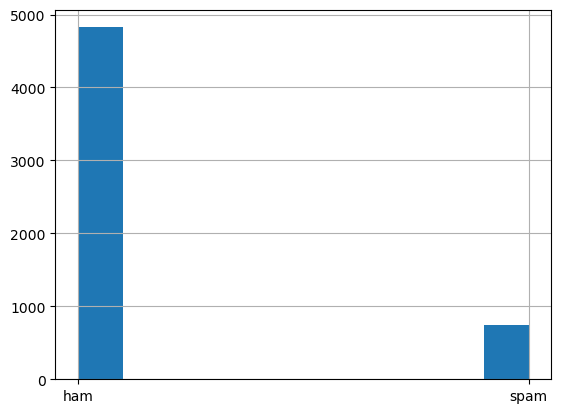

In [5]:
df["v1"].hist()

In [6]:
target_map = {"ham": 0 ,"spam" : 1}
df['target'] = df["v1"].map(target_map)
df.head()

,v1,v2,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
df_train, df_test, Y_train, Y_test = train_test_split(
    df['v2'], df["target"], test_size=0.33)

featurizer = CountVectorizer(decode_error='ignore')
X_train = featurizer.fit_transform(df_train)
X_test = featurizer.transform(df_test)

X_train = X_train.toarray()
X_test = X_test.toarray()
X_train.shape

(3733, 6944)

In [8]:
D = X_train.shape[1]

# build model
i = Input(shape=(D,))
x = Dense(1)(i) # sigmoid included in loss

model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6944)]            0         
                                                                 
 dense (Dense)               (None, 1)                 6945      
                                                                 
Total params: 6,945
Trainable params: 6,945
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy']
)

In [13]:
r = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=40,
    batch_size=128,
)

Epoch 1/40
30/30 [==============================] - 1s 20ms/step - loss: 0.1900 - accuracy: 0.9604 - val_loss: 0.1778 - val_accuracy: 0.9636
Epoch 2/40
30/30 [==============================] - 0s 11ms/step - loss: 0.1285 - accuracy: 0.9804 - val_loss: 0.1426 - val_accuracy: 0.9690
Epoch 3/40
30/30 [==============================] - 0s 9ms/step - loss: 0.0979 - accuracy: 0.9842 - val_loss: 0.1225 - val_accuracy: 0.9728
Epoch 4/40
30/30 [==============================] - 0s 8ms/step - loss: 0.0783 - accuracy: 0.9866 - val_loss: 0.1097 - val_accuracy: 0.9744
Epoch 5/40
30/30 [==============================] - 1s 19ms/step - loss: 0.0648 - accuracy: 0.9896 - val_loss: 0.0998 - val_accuracy: 0.9788
Epoch 6/40
30/30 [==============================] - 0s 10ms/step - loss: 0.0548 - accuracy: 0.9920 - val_loss: 0.0929 - val_accuracy: 0.9793
Epoch 7/40
30/30 [==============================] - 0s 9ms/step - loss: 0.0471 - accuracy: 0.9941 - val_loss: 0.0878 - val_accuracy: 0.9810
Epoch 8/40
30/30

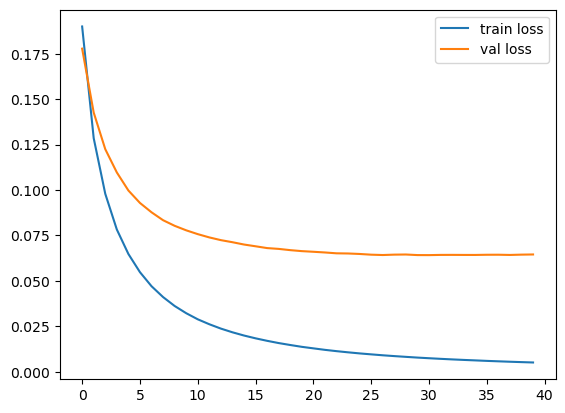

In [14]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

#notice how validation loss doesn't go smaller in each step
# as usual ML models perform better on train data than test data


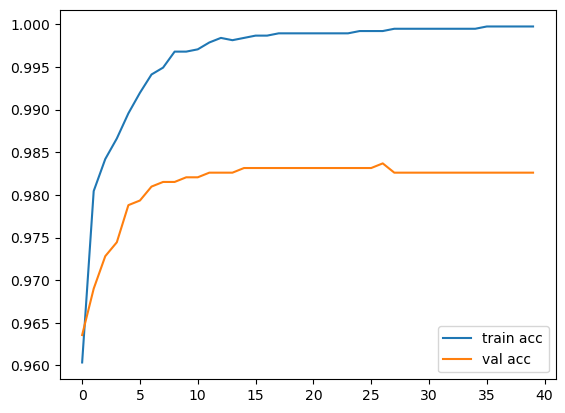

In [15]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();


In [16]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

58/58 [==============================] - 0s 3ms/step


array([[1.        , 0.        ],
       [0.00199601, 0.99800399]])

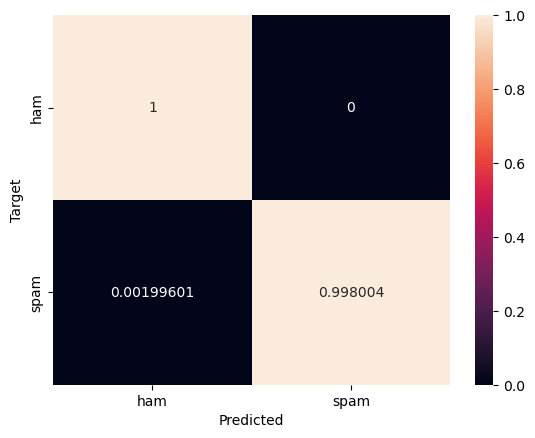

In [19]:
def plot_cm(cm):
  classes = ['ham', 'spam']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

#### BAYAAA İYİ

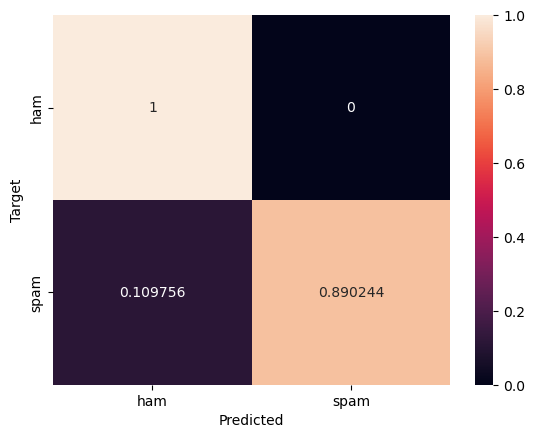

In [20]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
plot_cm(cm_test)

##spam'de biraz zorlanıyo

###BEN BU CONF MATRIXLERIN NEYİ GÖSTERDİĞİNİ ANLAMADIM, DATANN KAÇTA KAÇINI BİLDİ ONU MU?

In [21]:
Pr_train = model.predict(X_train)
Pr_test = model.predict(X_test)
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

print("Train F1:", f1_score(Y_train, P_train))
print("Test F1:", f1_score(Y_test, P_test))

58/58 [==============================] - 0s 2ms/step
Train AUC: 1.0
Test AUC: 0.9810680875170332
Train F1: 0.9990009990009989
Test F1: 0.9419354838709678


In [22]:
model.layers
w = model.layers[1].get_weights()[0]

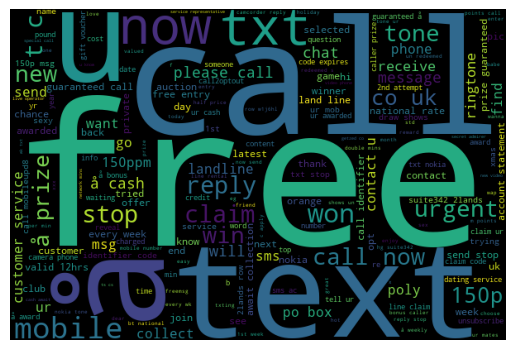

In [26]:
from wordcloud import WordCloud
def visualize(label):
  words = ''
  for msg in df[df['v1'] == label]['v2']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

visualize("spam")

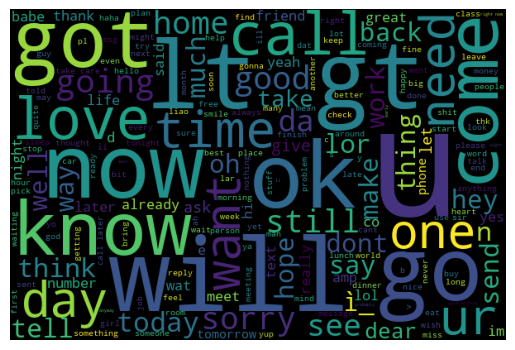

In [27]:
visualize("ham")

In [29]:
word_index_map = featurizer.vocabulary_
word_index_map

{'ps': 4899,
 'no': 4281,
 'ur': 6449,
 'grown': 2913,
 'up': 6433,
 'now': 4326,
 'right': 5177,
 'dear': 1946,
 '0776xxxxxxx': 27,
 've': 6507,
 'been': 1132,
 'invited': 3322,
 'to': 6215,
 'xchat': 6850,
 'this': 6142,
 'is': 3341,
 'our': 4474,
 'final': 2550,
 'attempt': 988,
 'contact': 1762,
 'txt': 6357,
 'chat': 1548,
 '86688': 599,
 '150p': 255,
 'msgrcvdhg': 4117,
 'suite342': 5887,
 '2lands': 333,
 'row': 5217,
 'w1j6hl': 6579,
 'ldn': 3613,
 '18yrs': 272,
 'changes': 1533,
 'da': 1900,
 'report': 5121,
 'big': 1178,
 'cos': 1795,
 'already': 803,
 'made': 3839,
 'previous': 4831,
 'coming': 1704,
 'back': 1048,
 'on': 4410,
 'thursday': 6172,
 'yay': 6877,
 'it': 3352,
 'gonna': 2849,
 'be': 1114,
 'ok': 4394,
 'get': 2788,
 'the': 6104,
 'money': 4067,
 'cheers': 1567,
 'oh': 4389,
 'yeah': 6879,
 'and': 838,
 'how': 3146,
 'are': 915,
 'you': 6902,
 'everything': 2382,
 'alright': 804,
 'hows': 3150,
 'school': 5309,
 'or': 4442,
 'do': 2111,
 'call': 1419,
 'work': 679

In [33]:
threshold = 2

print("Most spam words:")
word_weight_tuples = []
for word, weight in word_index_map.items():
    word_weight_tuples.append((word, weight))
    
word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])

for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)
    
    ## Anlamsız oldu :D

Most spam words:
ûówell 6943
ûò 6942
ûïharry 6941
ûï 6940
û_thanks 6939
û_ 6938
ó_ 6937
ìï 6936
ì_ 6935
åôrents 6934
